# PROGETTO DI INTRODUZIONE ALL'INTELLIGENZA ARTIFICIALE A.A 2023-2024:

## ABSTRACT
Questo studio si propone di replicare l'ambiente e gli agenti descritti nel paper ["Addiction beyond pharmacological effects: The role of environment complexity and bounded rationality"](https://www.sciencedirect.com/science/article/abs/pii/S0893608019301285) al fine di validare e comprendere più approfonditamente i risultati ottenuti nell'ambito del Reinforcement Learning. Il paper presenta un ambiente di simulazione e una serie di agenti intelligenti che operano all'interno di esso. L'obiettivo principale della nostra ricerca è quello di ricostruire fedelmente l'ambiente di simulazione e implementare gli agenti descritti utilizzando una libreria standard di Reinforcement Learning, come OpenAI Gym. 
Attraverso la ricreazione di questo ambiente e l'implementazione degli agenti, intendiamo esplorare le dinamiche sottostanti del problema descritto, testare le strategie di apprendimento automatico proposte e confrontare i risultati con quelli riportati nel paper originale. La nostra riproduzione dell'ambiente e degli agenti fornirà una base solida per ulteriori ricerche nel campo dell'apprendimento automatico e dell'intelligenza artificiale, consentendo una migliore comprensione e validazione dei risultati riportati nel paper.

### Recommender
Dopo aver riprodotto l'ambiente l'obiettivo è di implementare un multi armed bandit (UCB) e mostrare al variare del reward connesso all'arm B i diversi comportamenti. Fintantoché l’utente sceglie l’azione addictive ogni volta che può (perchè è nelle prime fasi dell’apprendimento o perchè ha risorse computazionali limitate), il recommender dovrebbe imparare a proporre lo stato A. Se e quando l’utente impara ad evitare l’azione addictive, il recommender dovrebbe imparare a scegliere B. 

**N.B.** non è detto che questo sistema a due agenti sia stabile, e non è detto che gli algoritmi utilizzati riescano a gestire la non stazionarietà. Per questi motivi, si consiglia di usare learning rate piccoli.

### Premessa
A causa della stocasticità del sistema, i risultati possono molto variare. L'agente MB ha problemi di esplorazione, quindi per colpa di questo, nei test su reward dell'arm B si è scelto di utilizzare solo l'agente MF che risulta più stabile, ma si possono utilizzare altri agenti MB e MX.

## MEMBRI DEL GRUPPO
Il progetto è stato svolto da: 
- Alessandro Verdi 886134
- Gabriele Maggi 886197

# IMPLEMENTAZIONE

In [49]:
import sys
sys.path.insert(0, '../')
sys.path.append('/home/gabriele/.conda/envs/progettoia/lib/python3.12/site-packages') # se non carica gymnasium mettere path modulo


import gymnasium as gym
print(f"Gym Version = {gym.__version__}")

import AddictiveReward

import numpy as np
import numba as nb
from numba.experimental import jitclass

from gymnasium.wrappers import RecordEpisodeStatistics
from gymnasium import spaces
import random
from numpy.random import choice
#from tqdm.notebook import tqdm
# from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from typing import Optional

Gym Version = 0.29.1


## DEFINIZIONE AMBIENTE
*Gli env v1 e v2 non sono supportati poichè vengono usati i metodi del recommender che non sono stati implementati in quegli envs*
### *"AddictiveEnv_v1"*

L'ambiente è stato implementato utilizzando la libreria Python Gym e simula un processo di transizione tra stale, con particolare enfasi sullo sviluppo dell'addizione. Gli stati sono definiti come segue:

- **Stato 1:** Healthy
- **Stati 2-n** Neutral
- **Stati 8-22:** Addicted

**Azioni:**

Sono disponibili nove azioni distinte:

- **as2-as7:** Per spostarsi rispettivamente negli stati 2-7 dagli stati neutrali.
- **ag:** Per spostarsi nello stato Healthy.
- **aw e ad:** Per avanzare nell'addizione.

**Ricompense:**

Le ricompense sono definite come segue:

- **+1:** Una volta che l'agente entra nello stato Healthy.
- **+10:** Una volta che l'agente entra negli stati Addicted.
- **-4:** Per uscire dagli stati Addicted.
- **-1 e -2:** Per muoversi tra gli stati Addicted.



### *"AddictiveEnv_v2-3"*
L'ambiente è stato implementato utilizzando la libreria Python Gym e simula un processo di transizione tra stati, con particolare enfasi sullo sviluppo dell'addizione. Gli stati sono definiti come segue:

- **Stato 1:** Healthy
- **Stato 2** Neutral
- **Stato 3:** Addicted
- **Stato 4:** After-effects

**Azioni:**

Sono disponibili cinque azioni distinte:

- **as2-as3:** Per spostarsi rispettivamente negli stati 2-3 dagli stati 2-3.
- **ag:** Per spostarsi nello stato Healthy.
- **aw e ad:** Per avanzare nell'addizione.

**Ricompense:**

Le ricompense sono definite come segue:

- **+1:** Una volta che l'agente entra nello stato Healthy.
- **+10:** Una volta che l'agente entra negli stati Addicted.
- **-20:** Per uscire dagli stati Addicted.
  
### Recommender (Env_v3)
Il recommender può scegliere di cambiare lo stato Addicted (3) con uno stato 'B' avente una transizione che porta allo stato Neutral avente un Reward compreso tra [-2:2]

Dal punto di vista del recommender, il problema è un multi armed bandit con due azioni o arm “A (addicted)” e “B” e la seguente funzione di ricompensa:
- R_t = **+1** se l’utente si trova nello stato A o B e sceglie l’azione potenzialmente addictive (la freccia tratteggiata nel disegno)
- R_t = **-1** se l’utente si trova in A o B e sceglie l’altra azione
- R_t = **0** in ogni altro caso

## IMPLEMENTAZIONE AMBIENTE

In [50]:
env = gym.make('AddictiveEnv_v3')

### FUNZIONI UTILI 

In [51]:
def data_plot():
    timestamps_arm = env.unwrapped.get_statistics() 
    time_values = np.arange(len(timestamps_arm))
     
    plt.figure(figsize=(16, 12))
    # Plot for total_reward
    plt.subplot(2, 2, 1)
    plt.plot(total_reward, label='Total Reward')
    plt.title('Total Reward (A)')
    plt.xlabel('Steps')
    plt.ylabel('Total reward')
    plt.legend()
    # plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)

    # Plot of reward foreach arm
   
    plt.subplot(2, 2, 2)
    plt.plot(test_rew_a, label='recommender A')
    plt.plot(test_rew_b, label='recommender B')
    plt.title('Arm rewards (B)')
    plt.xlabel('Steps')
    plt.ylabel('Total Reward')
    plt.legend()
    # plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)  
   
    plt.subplot(2, 2, 3)
    plt.scatter(time_values, timestamps_arm, marker='o', linestyle='-')
    plt.yticks([0, 1], ['Addicted arm A', 'Healthy arm B'])
    plt.title('Addicted Arm: 0 = Addictive, 1 = Healthy (C)')
    plt.xlabel('Steps')
    plt.ylabel('Choice')
    #plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)
    # plt.subplot(2, 2, 4)
    # plt.grid(True, linestyle=':', color='gray', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
import heapq
class PriorityQueue:
    def __init__(self):
        self._queue = []
        self._index = 0

    def is_empty(self):
        if self._queue  == []:
            return True
        return False
        
    def insert(self, item, priority):
        heapq.heappush(self._queue, (priority, self._index, item))
        self._index += 1

    def clean(self):
        self._queue = []
        self.index = 0
        
    def pop(self):
        return heapq.heappop(self._queue)[-1]

## AGENTE MF

### IMPLEMENTAZIONE AGENTE MF
L'agente MF basato su Q-Learning volto a stimare il valore di una Q(s, a) ottimale (dalla quale poi estrarre la politica ottimale) in un ambiente senza avere conoscenza diretta del modello di transizione di stato o delle ricompense. 

In [52]:
class MFLearningAgent:
    def __init__(self, 
                 learning_rate: float,  
                 initial_epsilon: float, 
                 epsilon_decay: float,  
                 final_epsilon: float, 
                 discount_factor: float = 0.9):
        
        # Initialize parameters
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        # Initialize Q-values table
        self.q_values = np.zeros([env.observation_space.n, env.action_space.n])

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.training_error = []  # Track training error during training

    def get_action(self, state):
        # Choose action using epsilon-greedy strategy
        if random.uniform(0, 1) < self.epsilon: # epsilon greedy 
            return env.action_space.sample() # Explore action space
        else:
            return np.argmax(self.q_values[state]) # Exploit learned values

    def update(self, obs: int, action: int, reward: float, terminated: bool, next_obs: int):
        # Update Q-values using Q-learning equation
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (reward + self.discount_factor * future_q_value - self.q_values[obs][action])
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

        
    def decay_epsilon(self):
       # Decay epsilon value
       self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

### TEST MF

In [53]:
lr = 0.01
start_epsilon = 0.4
epsilon_decay = start_epsilon / (env.unwrapped.get_iter() / 2)  # reduce the exploration over time
final_epsilon = 0.1
discount_factor = 0.9

agentMF = MFLearningAgent(
    learning_rate = lr,
    initial_epsilon = start_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon,
    discount_factor = discount_factor,
)


In [65]:
total_reward = []
healthy_rates = []
addicted_rates = []
###
test_rew_a = []
test_rew_b = []
r_a = 0
r_b = 0
###


pbar = tqdm(total = env.unwrapped.get_iter()+1)

obs, info = env.reset()
done = False
addicted = 0
healthy = 0

r = 0
healty_arm = 0
addicted_arm = 0

a_count = 1
h_count = 1



while not done:
    action = agentMF.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)

    agentMF.update(obs, action, reward, terminated, next_obs)
    
    if obs == 3 and action == 4:
        a_count += 1
    elif obs == 1 and next_obs == 2:
        h_count += 1
        
    done = terminated or truncated
    obs = next_obs
    r += reward

    ##
    rewards = env.unwrapped.get_rewards()
    
    r_a = rewards[0]
    r_b = rewards[1]
    
    test_rew_a.append(r_a)
    test_rew_b.append(r_b)
    ##
    total_reward.append(r)
    addicted_rates.append(a_count)
    healthy_rates.append(h_count)
    
    pbar.update(1)


pbar.close()

  0%|          | 0/5001 [00:00<?, ?it/s]

### DATA MF

In [66]:
print(f"addicted {a_count}")
print(f"healthy {h_count}")



addicted 471
healthy 320


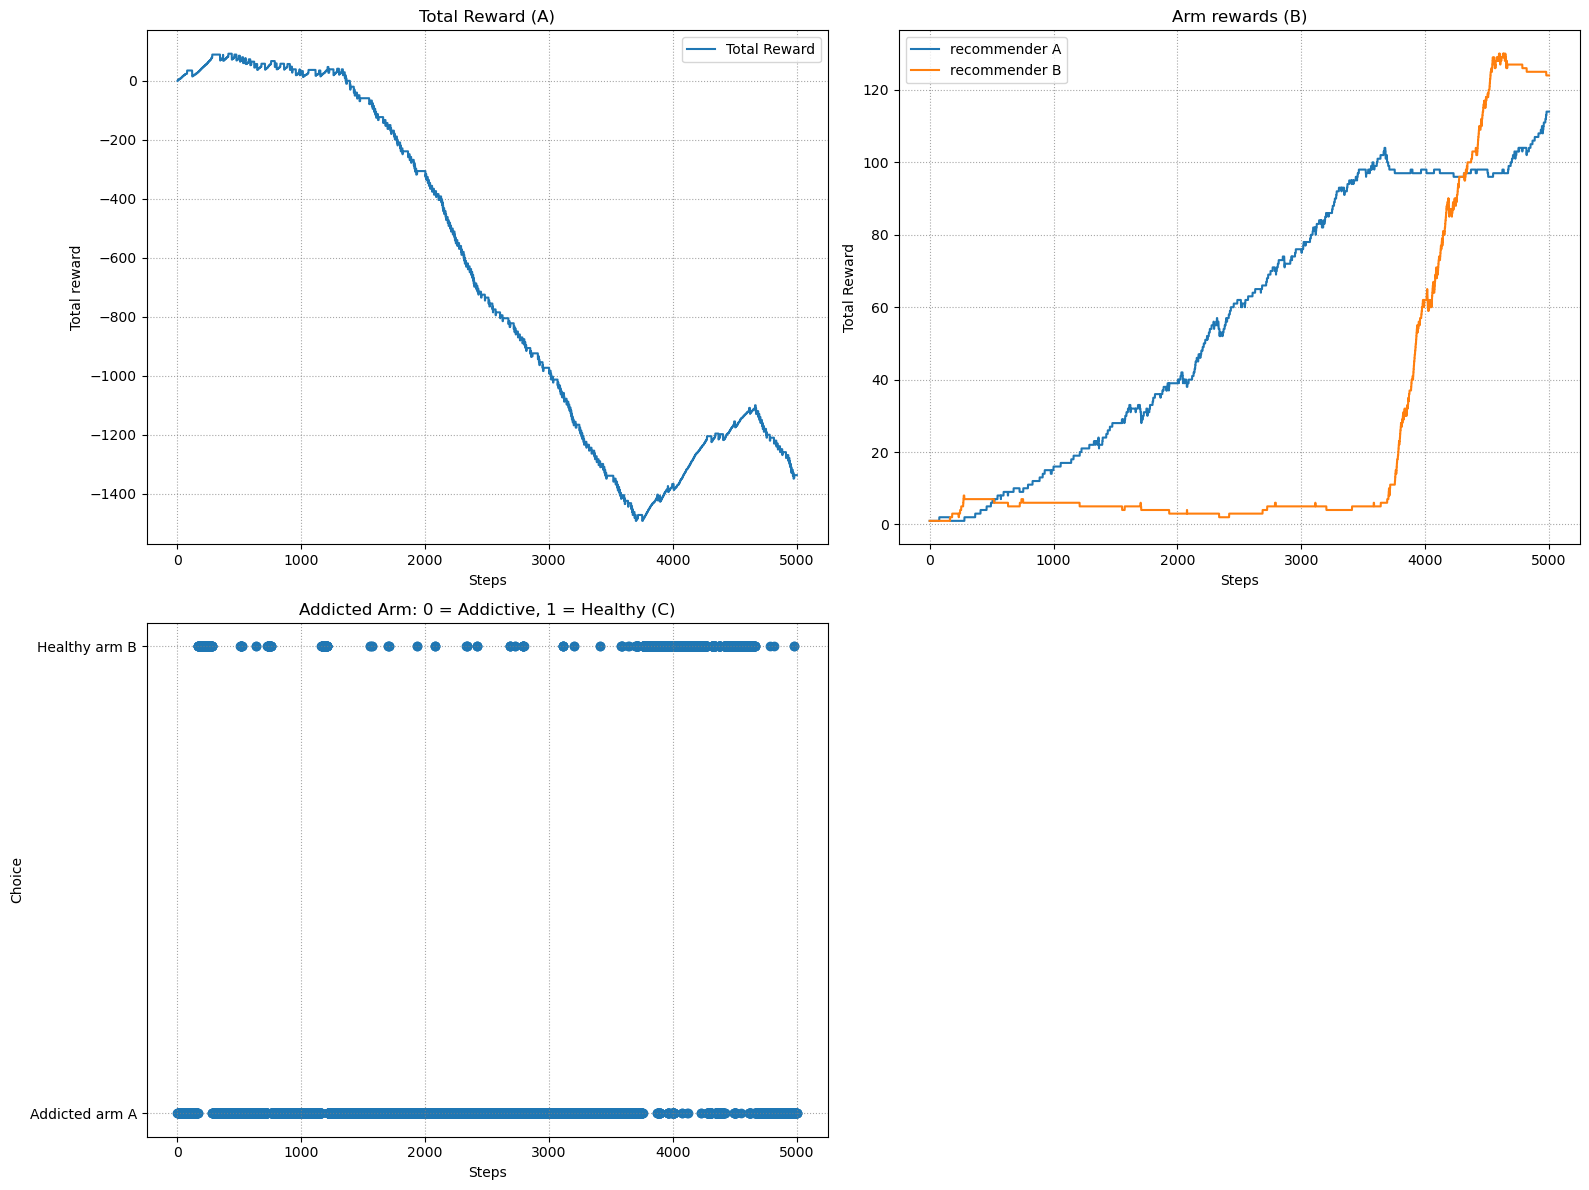

In [67]:
data_plot()

#### Spiegazione grafici:
- **A**: Rappresenta il reward cumulativo al variare degli steps
- **B**: Rappresenta il variare dei reward degli arm per ogni steps
- **C**: Rappresenta quale è l'attuale braccio per ogni step

Si nota che quando l'agente comincia a prediligere un comportamento healty (caratterizzato in A da una salita omogenea) il recommender comincia a consigliare l'arm B e viceversa.

## AGENTE MB

##### JIT OPTIMIZED FUNCTIONS ####

In [69]:
def transition_model_to_numpy(transition_model, obs_space, action_space):
    transition_array = np.zeros((obs_space, action_space, obs_space, 3)) 
    for state in range(1, obs_space):
        for action in range(action_space):
            for next_state in range(1, obs_space):
                transition_info = transition_model[state][action].get(next_state, {'count': 0, 'probability': 0, 'reward': 0})
                transition_array[state, action, next_state] = [transition_info.get('count', 0), transition_info.get('probability', 0), transition_info.get('reward', 0)]

    return transition_array



@nb.jit
def value_iteration_gpu(iterations, obs_space, action_space, transition_model, discount_factor, q_values):
    epsilon = 0.1
    delta = 1.0  
    
    while iterations > 0 and delta > epsilon: # check for iteration (MBUS) or convergence
        delta = 0
        
        for state in range(1, obs_space):
            for action in range(action_space):
                t = 0
                for next_state in range(1, obs_space):
                    count, probability, reward = transition_model[state, action, next_state]
                    t += probability * (reward + discount_factor * np.max(q_values[next_state]))
                q_values[state, action] = t
            
                # Calculate delta
                Vs = abs(q_values[state, action] - np.max(q_values[state]))
                delta = max(delta, Vs)
        
        iterations -= 1  # Decrease the number of iterations
    
    return q_values

### IMPLEMENTAZIONE AGENTE MB
L'agente MB è realizzato utilizzando la value iteration per ricavare le politiche ottimali

In [101]:
class MBLearningAgent:
    def __init__(self, learning_rate: float, initial_epsilon: float, epsilon_decay: float, final_epsilon: float, discount_factor: float = 0.9, mbus = 50 ,theta=0.01):
        
        # MB params
        self.q_values = np.zeros([env.observation_space.n, env.action_space.n])

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        self.mbus = mbus
        self.transition_model = {} 
        self.initialize_transition_model()
        
        self.training_error = []
        
        self.pred_queue = PriorityQueue()
        self.theta = theta 
        self.upd = 0
    
    def get_action(self, state):
        if random.uniform(0, 1) < self.epsilon: # epsilon greedy 
            return env.action_space.sample() # Explore action space
        else:
            return np.argmax(self.q_values[state]) # Exploit learned values

    def value_iteration(self, iter): # no convergence old
        epsilon = 0.1
        for _ in range(1, iter):
            delta = 0
            for state in range(1, env.observation_space.n):
                for action in range(0,  env.action_space.n):
                    t = 0
                    for next_state in self.transition_model[state][action]:
                        probability = self.transition_model[state][action][next_state]['probability']
                        reward = self.transition_model[state][action][next_state]['reward']
                        t += probability * (reward + self.discount_factor * np.max(self.q_values[next_state]))
                    self.q_values[state][action] = t
                     
                Vs = abs(self.q_values[state][action] - np.max(self.q_values[state]))
                delta = max(delta, Vs)
                
            if delta < epsilon and delta > 0: # convergenza
                break
                
    # Prioritized sweeping test 
    def prioritized_sweeping(self, state, action):
        self.calculate_sweep(state, action)
        while not (self.pred_queue.is_empty()):
            if self.upd > self.mbus:
                #print("stopped")
                self.pred_queue.clean()
                break
            state = self.pred_queue.pop()
                        
            for state_p in range(1, env.observation_space.n):
                for action_p in range(env.action_space.n): 
                    for next_state_p in self.transition_model[state_p][action_p]:
                        if next_state_p == state:
                            self.calculate_sweep(state_p, action_p)
                            

    def calculate_sweep(self, state, action):
        old_q = self.q_values[state][action]
        new_q = 0
        
        for next_state in self.transition_model[state][action]:
            probability = self.transition_model[state][action][next_state]['probability']
            reward = self.transition_model[state][action][next_state]['reward']
            new_q += probability * (reward + self.discount_factor * np.max(self.q_values[next_state]))
        self.q_values[state][action] = new_q
        p = abs(new_q - old_q)
        if p > 0:
            self.upd += 1
            max_q = np.max(self.q_values[state])
            if old_q == max_q or new_q == max_q:
                 self.pred_queue.insert(state, p)
       
    def initialize_transition_model(self):
        for state in range(1, env.observation_space.n):
            self.transition_model[state] = {}
            for action in range(env.action_space.n):
                self.transition_model[state][action] = {}
                for next_state in range(env.observation_space.n):
                    self.transition_model[state][action][next_state] = {'count': 0, 'probability': 0, 'reward': 0}
    
    # Facade for MF compability
    def update(self, obs, action, reward, terminated, next_obs):
        self.update_transition_model(obs, action, next_obs, reward)
        
    def update_transition_model(self, state, action, next_state, reward):
        self.transition_model[state][action][next_state]['count'] += 1
        self.transition_model[state][action][next_state]['reward'] = reward
        self.calculate_transition_probabilities()

        # For changing calculation method remove the comment and comment the other
        #1. prioritized sweeping
        #self.prioritized_sweeping(obs, action)
        
        #2. value iteration JIT optimized (FAST)
        transition_array = transition_model_to_numpy(self.transition_model, env.observation_space.n, env.action_space.n)
        self.q_values = value_iteration_gpu(self.mbus, env.observation_space.n, env.action_space.n, transition_array, self.discount_factor, self.q_values)
        
        #3. value iteration (SLOW)
        #self.value_iteration(self.mbus)
        
    def calculate_transition_probabilities(self):
        for state in range(1, env.observation_space.n):
            for action in range(env.action_space.n):
                total_count = sum(self.transition_model[state][action][next_state]['count'] for next_state in self.transition_model[state][action])
                for next_state in self.transition_model[state][action]:
                    
                    c = self.transition_model[state][action][next_state]['count']
                    if total_count == 0:
                        total_count = 1
                    self.transition_model[state][action][next_state]['probability'] = c / total_count
    
    def decay_epsilon(self):
       self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
    

### TEST MB

In [76]:
lr = 0.01
n_episodes = 1

start_epsilon = 0.4
epsilon_decay = start_epsilon / (env.unwrapped.get_iter() / 2)  # reduce the exploration over time
final_epsilon = 0.1

discount_factor = 0.9

agentMB = MBLearningAgent(
    learning_rate = lr,
    initial_epsilon = start_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon,
    discount_factor = discount_factor,
    mbus = 5 # early stopping of value iteration
)

In [77]:
addiction_states = []
total_reward = []
healty_states = []
healthy_rates = []
addicted_rates = []

pbar = tqdm(total = env.unwrapped.get_iter() + 1)

obs, info = env.reset()

done = False
addicted = 0
healthy = 0
r = 0

healty_arm = 0
addicted_arm = 0

a_count = 1
h_count = 1

###
test_rew_a = []
test_rew_b = []
r_a = 0
r_b = 0
###

step = 1
# play one episode
while not done:
    action = agentMB.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)

    # update the agent
    agentMB.update_transition_model(obs, action, next_obs, reward)
            
    if obs == 3 and next_obs == 4:
        a_count += 1 
    elif obs == 2 and next_obs == 1:
        h_count += 1

    
    done = terminated or truncated
    obs = next_obs
    r += reward

    ##
    rewards = env.unwrapped.get_rewards()
    
    r_a = rewards[0]
    r_b = rewards[1]
    
    test_rew_a.append(r_a)
    test_rew_b.append(r_b)
    ##
    
    
    agentMB.decay_epsilon()

    total_reward.append(r)    
    addicted_rates.append(a_count)
    healthy_rates.append(h_count )
    
    pbar.update(1)

pbar.close()

  0%|          | 0/5001 [00:00<?, ?it/s]

### DATA MB

In [74]:
agentMB.transition_model[3][4]

{0: {'count': 0, 'probability': 0.0, 'reward': 0},
 1: {'count': 0, 'probability': 0.0, 'reward': 0},
 2: {'count': 46, 'probability': 0.24598930481283424, 'reward': 2},
 3: {'count': 0, 'probability': 0.0, 'reward': 0},
 4: {'count': 141, 'probability': 0.7540106951871658, 'reward': 10}}

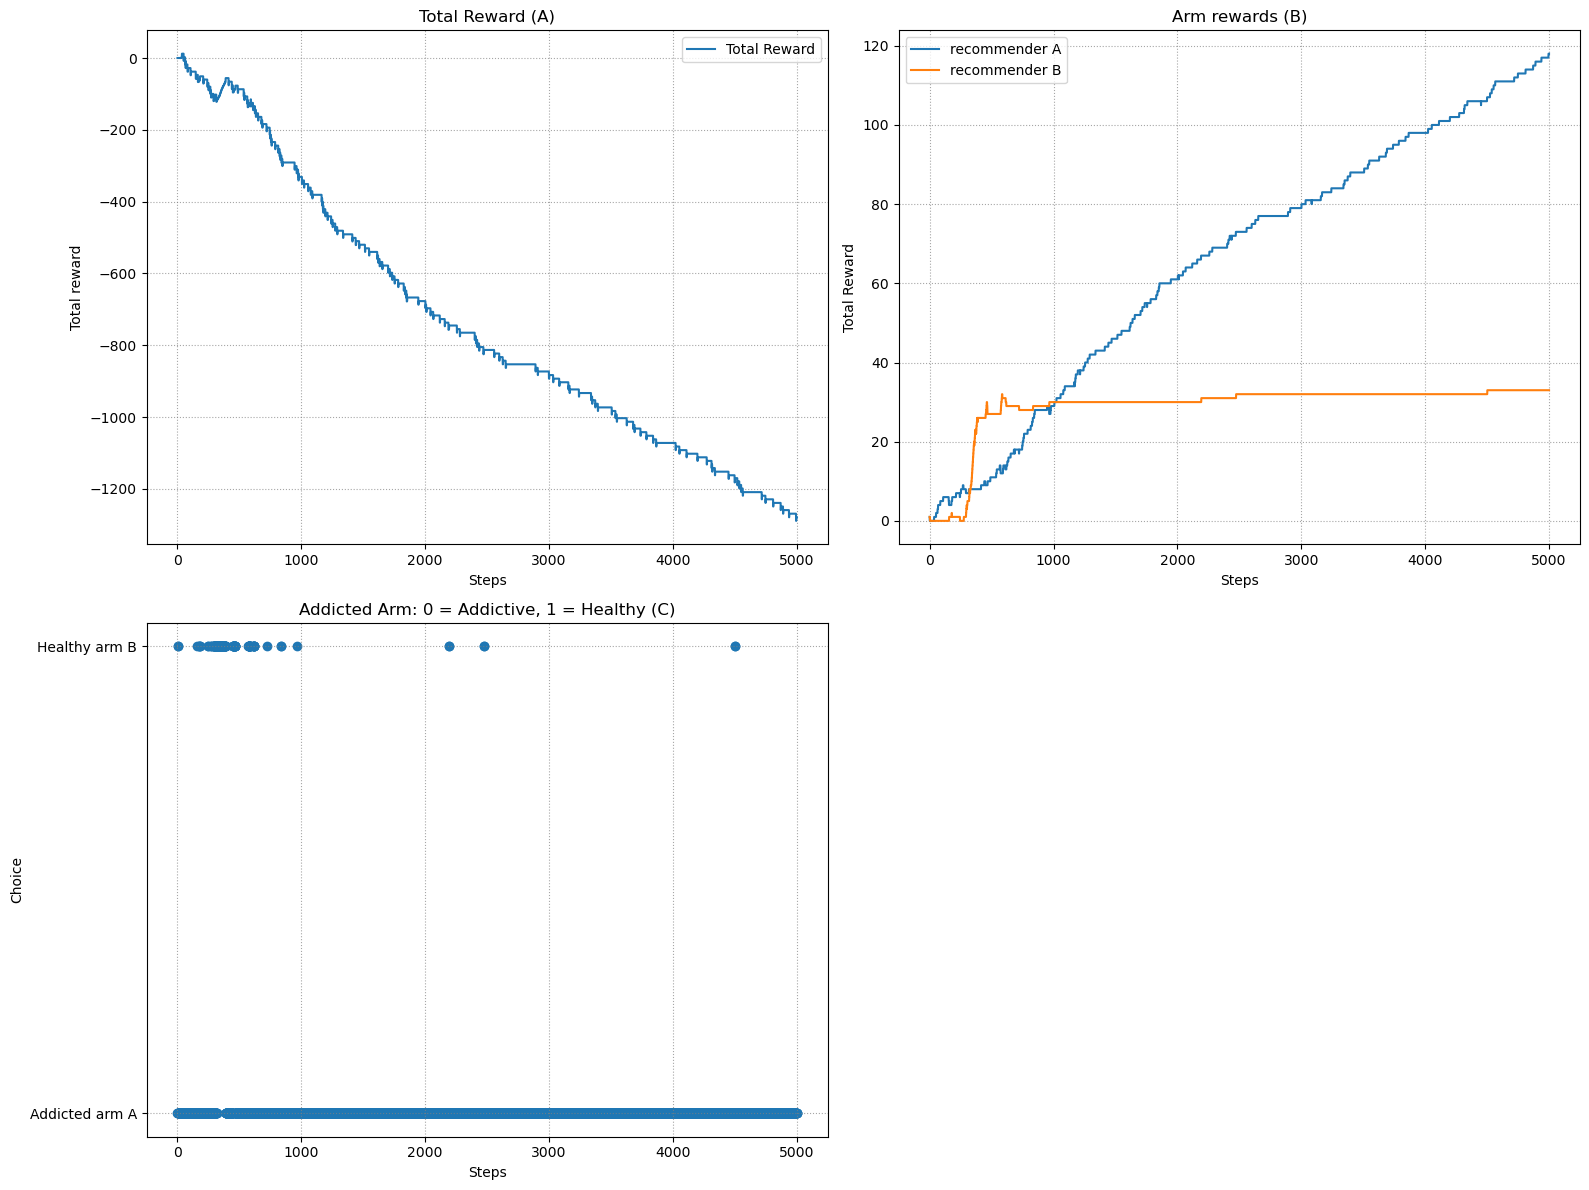

In [75]:
data_plot()

#### Spiegazione grafici:
- **A**: Rappresenta il reward cumulativo al variare degli steps
- **B**: Rappresenta il variare dei reward degli arm per ogni steps
- **C**: Rappresenta quale è l'attuale braccio per ogni step

Si nota che quando l'agente comincia a prediligere un comportamento healty (caratterizzato in A da una salita omogenea) il recommender comincia a consigliare l'arm B e viceversa.

## AGENTE MX

### IMPLEMENTAZIONE AGENTE MX

In [96]:
class MXLearningAgent:
    def __init__(self, lr, ie, ed, fe, Beta, Epsilon, MBUS):
        self.MF_agent = MFLearningAgent(
                            learning_rate = lr,
                            initial_epsilon = ie,
                            epsilon_decay = ed,
                            final_epsilon = fe,
                        )
        self.MB_agent = MBLearningAgent(
                            learning_rate = lr,
                            initial_epsilon = ie,
                            epsilon_decay = ed,
                            final_epsilon = fe,
                            mbus = MBUS
                        )
        self.beta = Beta # Balance model based and model free
        self.epsilon = Epsilon
        self.q_valuesMX = np.zeros([env.observation_space.n, env.action_space.n])
        
    def get_action(self, state):
        if random.uniform(0, 1) > self.epsilon:
                return np.argmax(self.q_valuesMX[state]) 
        else:
            return env.action_space.sample()
            
    def update(self, obs, action, reward, terminated, next_obs):
        self.MF_agent.update(obs, action, reward, terminated, next_obs)
        self.MF_agent.decay_epsilon()
        self.MB_agent.update_transition_model(obs, action, next_obs, reward)
        self.MB_agent.decay_epsilon()
        for s in range(1, env.observation_space.n):
            for a in range(env.action_space.n):
                 self.q_valuesMX[s][a] = self.beta * self.MB_agent.q_values[s][a] + (1-self.beta) * self.MF_agent.q_values[s][a]
        

### TEST MX

In [97]:
lr = 0.01
n_episodes = 1

ie = 0.4
ed = ie / (env.unwrapped.get_iter() / 2)  # reduce the exploration over time
fe = 0.1

beta = 0.3

agentMX = MXLearningAgent(
    lr = lr,
    ie = ie,
    ed = ed,
    fe = fe,
    Beta = beta,
    Epsilon = 0.1,
    MBUS = 5,
)



In [98]:
addiction_states = []
total_reward = []
healty_states = []
healthy_rates = []
addicted_rates = []

pbar = tqdm(total = env.unwrapped.get_iter() + 1)

obs, info = env.reset()

done = False
addicted = 0
healthy = 0
r = 0

healty_arm = 0
addicted_arm = 0

a_count = 1
h_count = 1

###
test_rew_a = []
test_rew_b = []
r_a = 0
r_b = 0
###

step = 1
# play one episode
while not done:
    action = agentMX.get_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)

    # update the agent
    agentMB.update_transition_model(obs, action, next_obs, reward)
            
    if obs == 3 and next_obs == 4:
        a_count += 1 
    elif obs == 2 and next_obs == 1:
        h_count += 1

    
    done = terminated or truncated
    obs = next_obs
    r += reward

    ##
    rewards = env.unwrapped.get_rewards()
    
    r_a = rewards[0]
    r_b = rewards[1]
    
    test_rew_a.append(r_a)
    test_rew_b.append(r_b)
    ##
    
    total_reward.append(r)    
    addicted_rates.append(a_count)
    healthy_rates.append(h_count )
    
    pbar.update(1)

pbar.close()

  0%|          | 0/5001 [00:00<?, ?it/s]

### DATA MX

In [99]:
agentMX.MF_agent.q_values
print(h_count)
print(a_count)

55
2


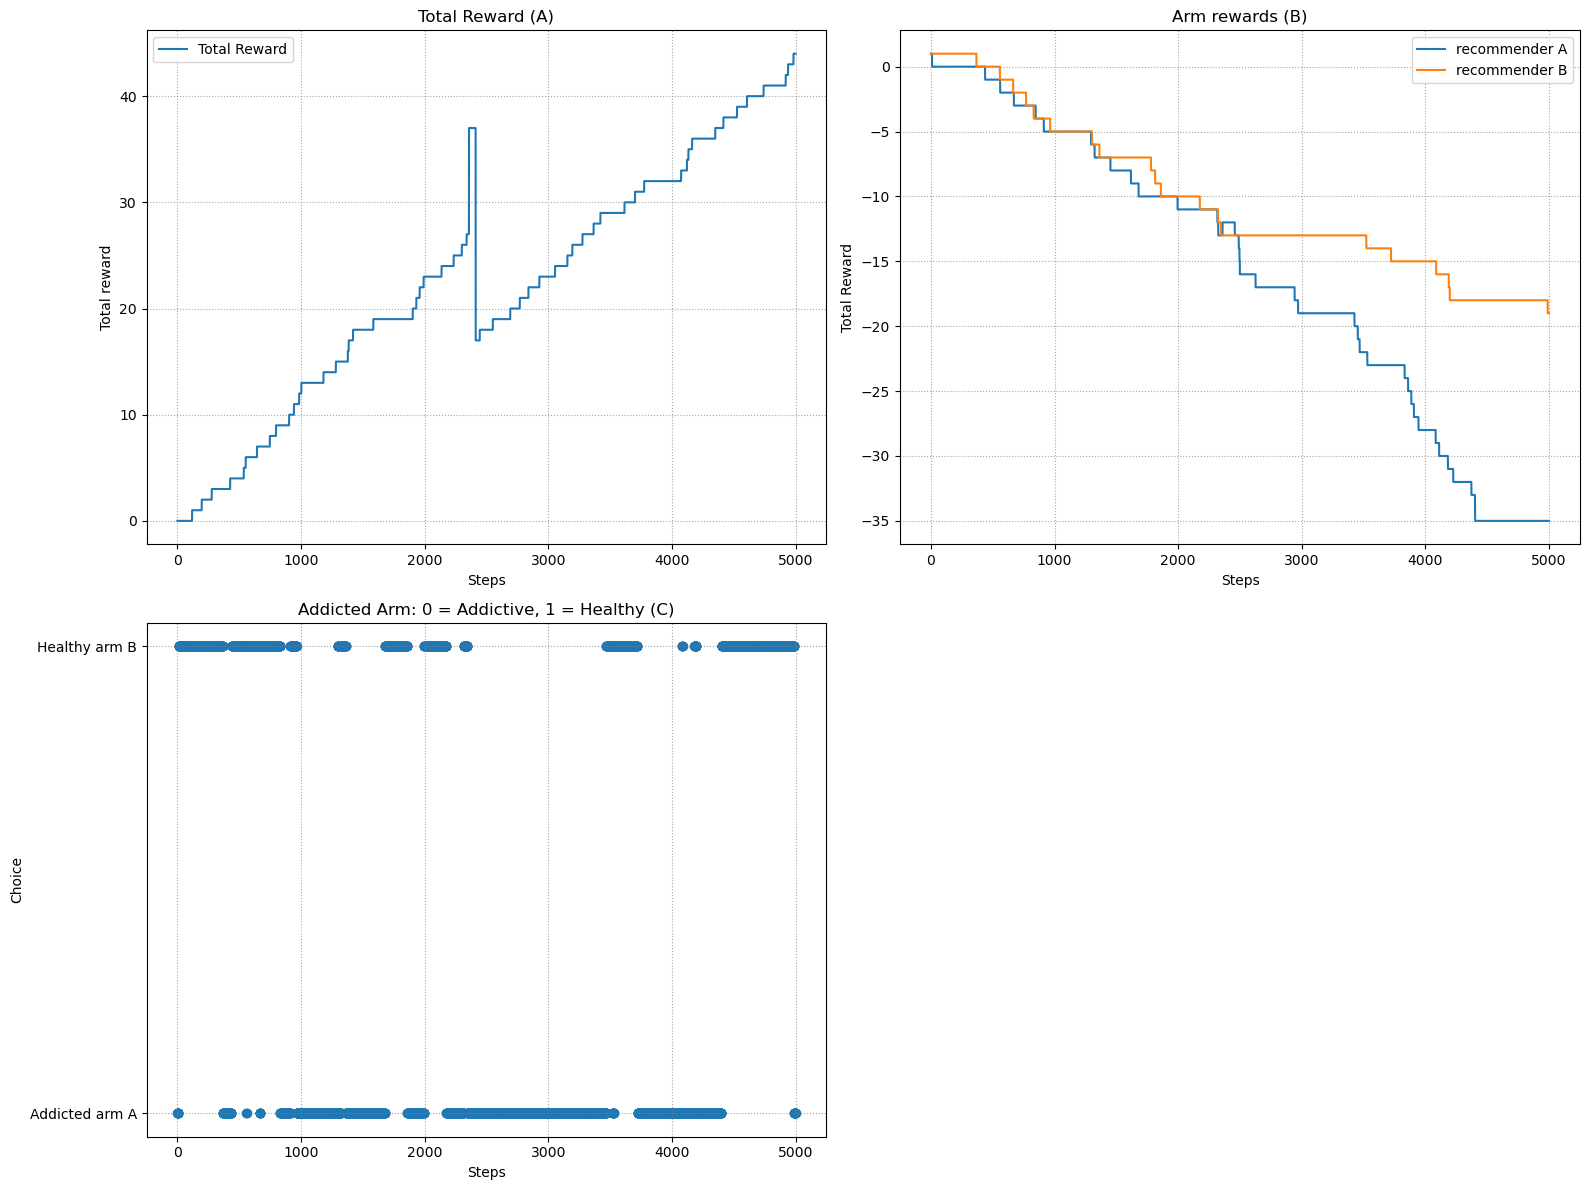

In [100]:
data_plot()

#### Spiegazione grafici:
- **A**: Rappresenta il reward cumulativo al variare degli steps
- **B**: Rappresenta il variare dei reward degli arm per ogni steps
- **C**: Rappresenta quale è l'attuale braccio per ogni step

Si nota che quando l'agente comincia a prediligere un comportamento healty (caratterizzato in A da una salita omogenea) il recommender comincia a consigliare l'arm B e viceversa.

## MULTIPLE AGENT TEST

### MULTI NHR

Agent Loop:   0%|          | 0/600 [00:00<?, ?it/s]

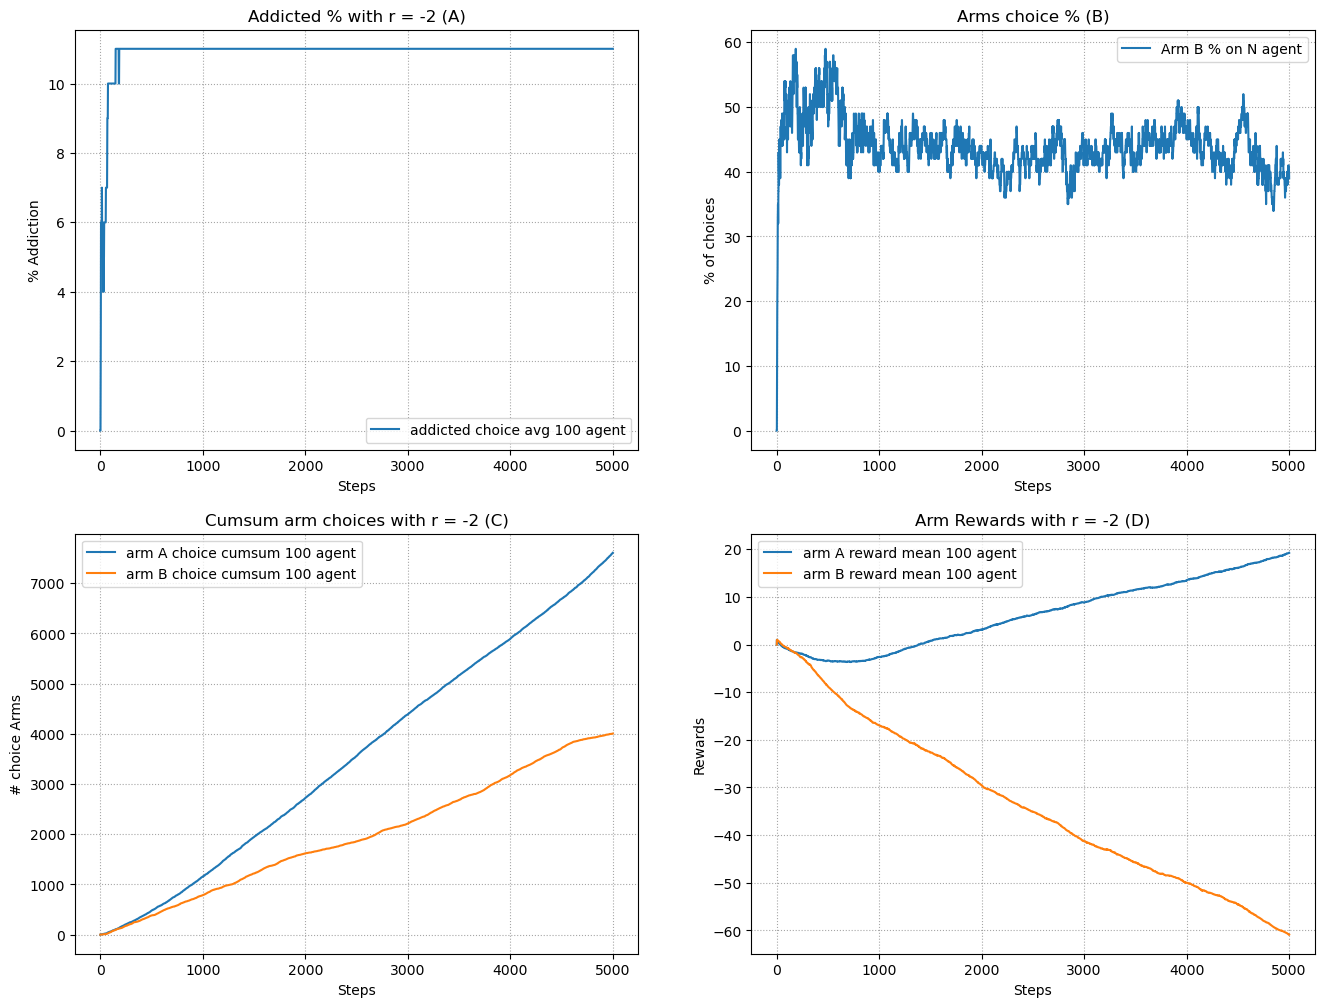

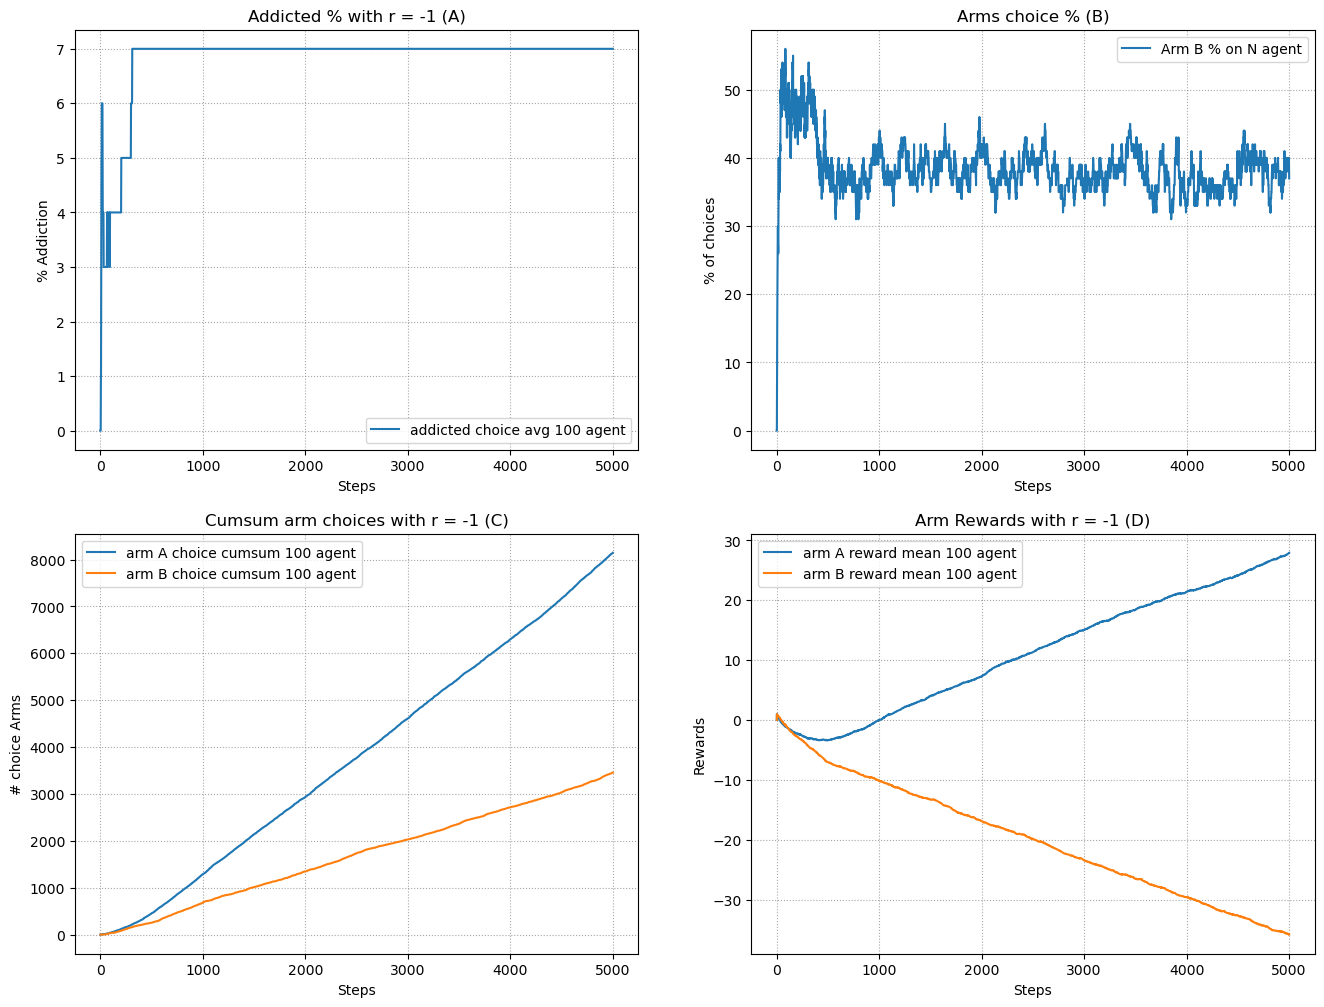

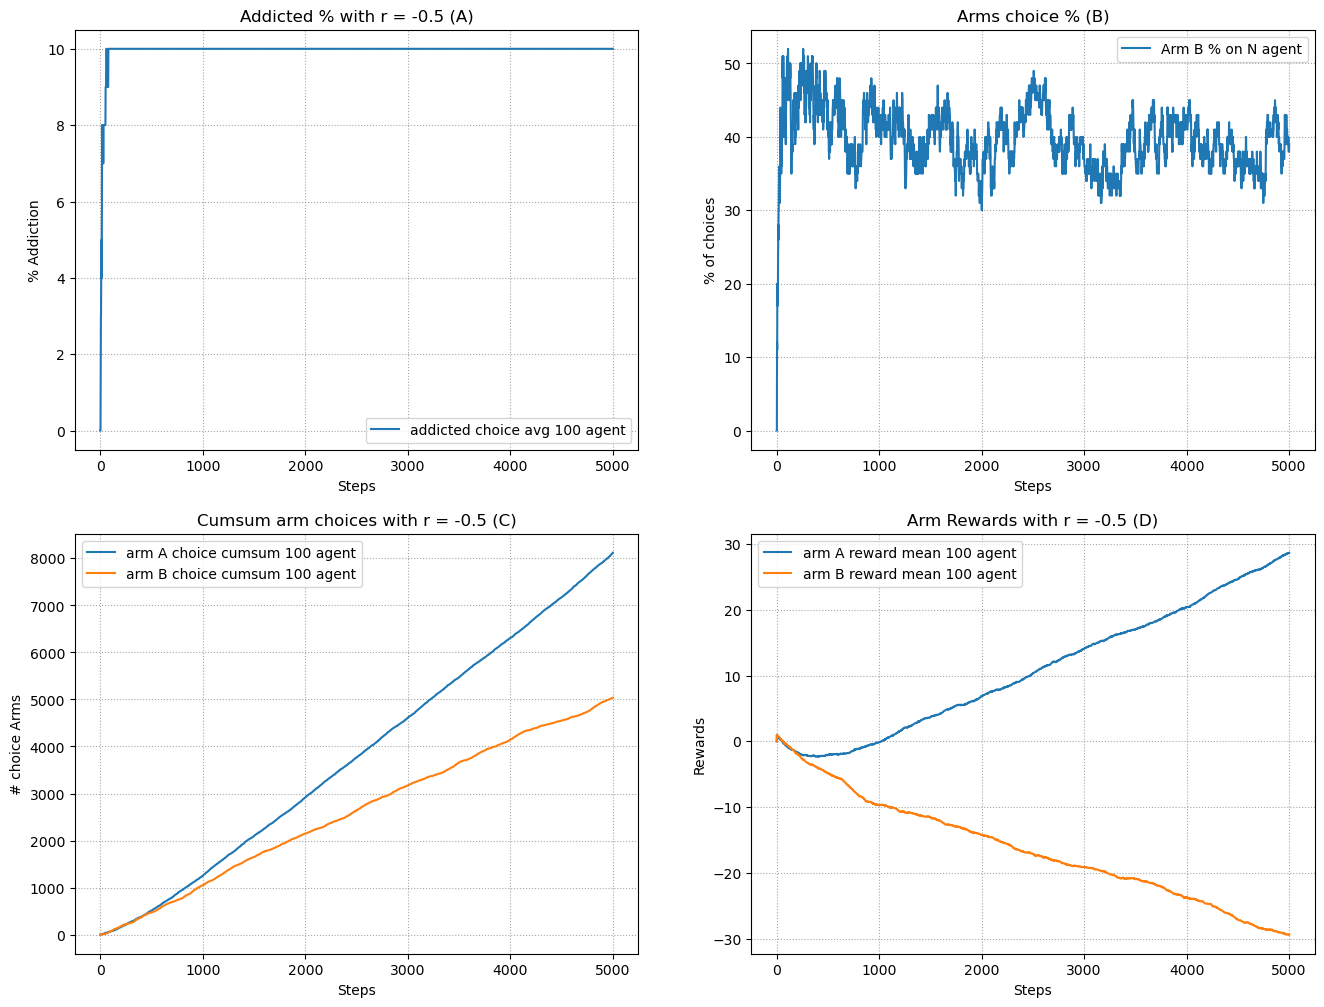

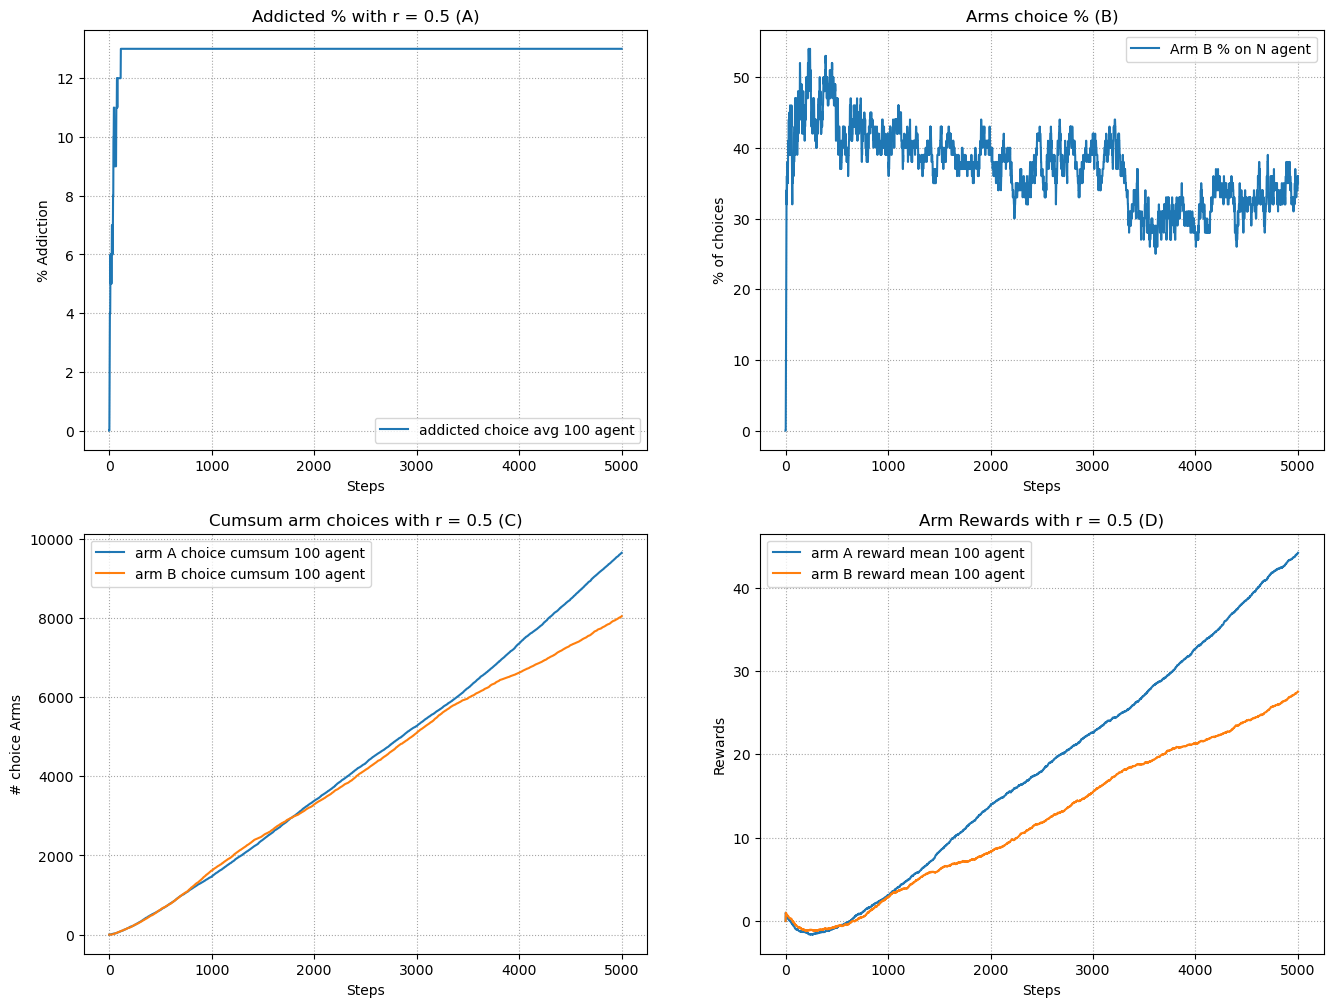

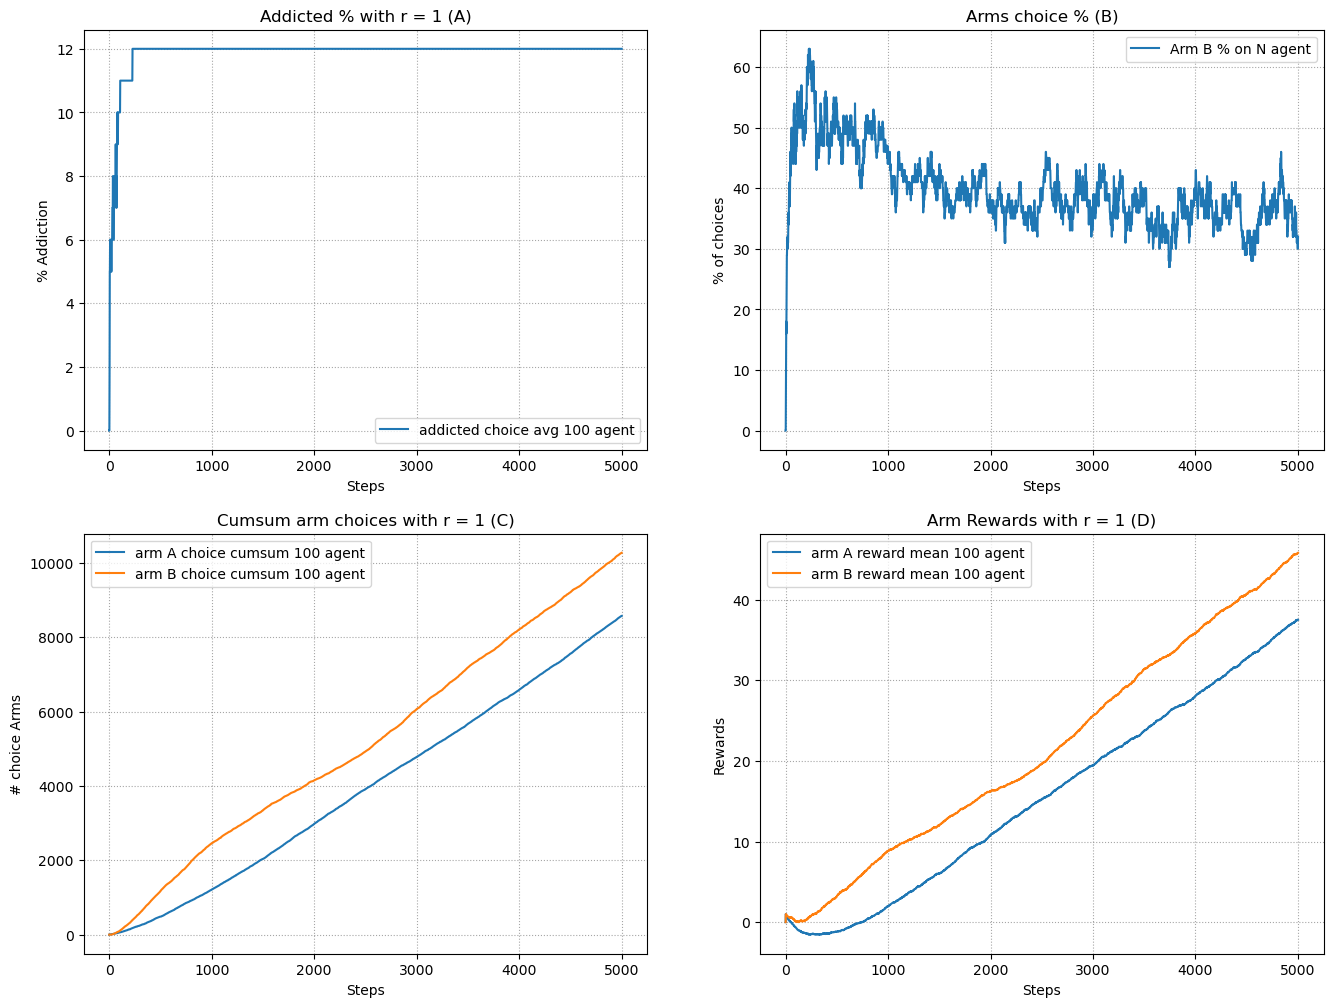

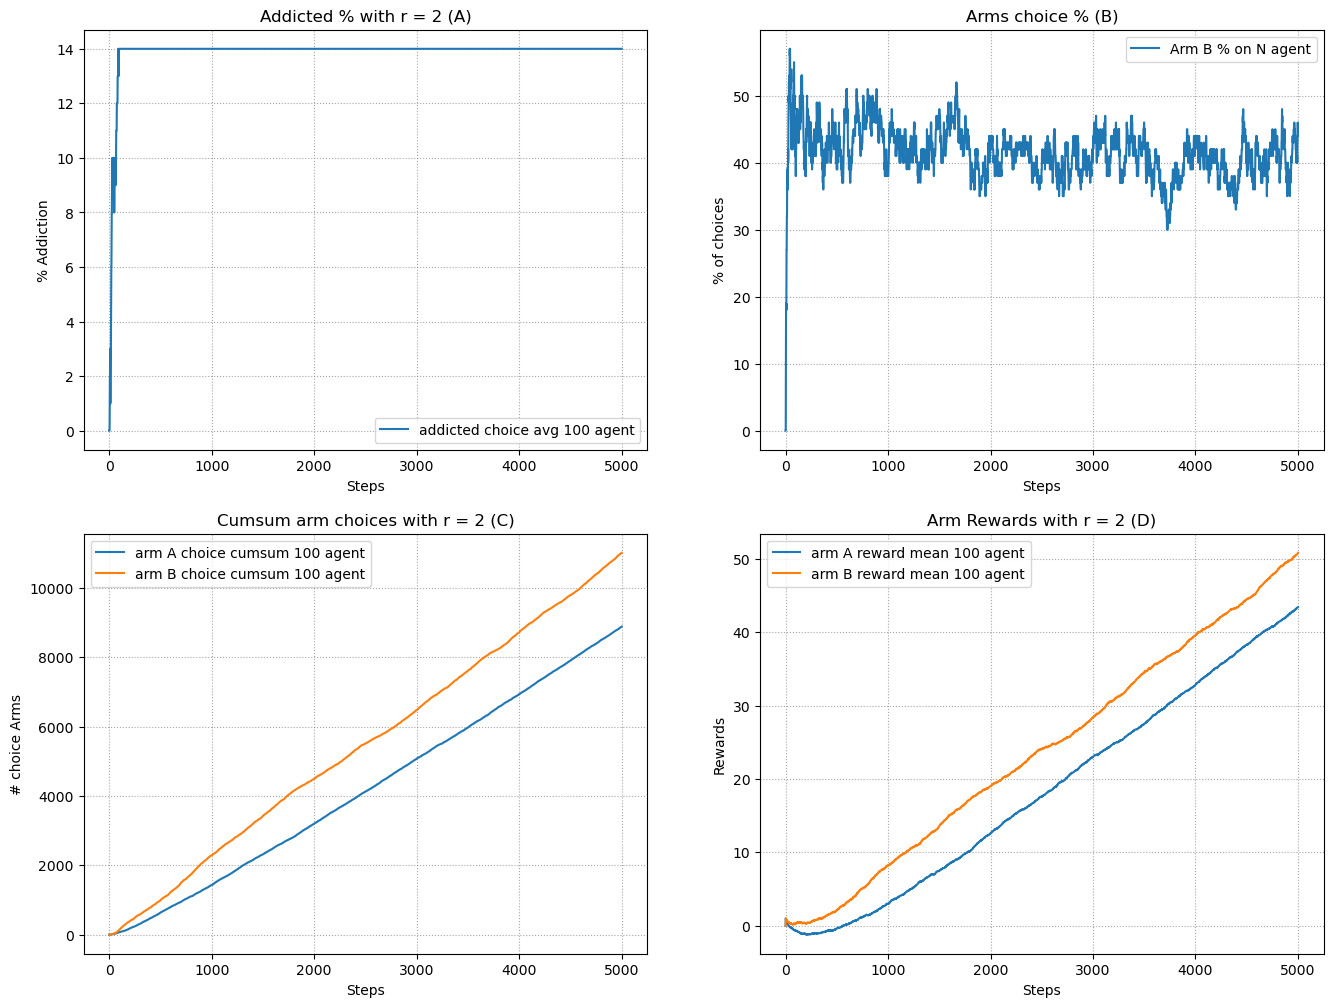

In [93]:
# agenti
agents = []
addiction_states = []
rewards = [-2, -1, -0.5, 0.5, 1, 2]


# parametri
lr = 0.01


nagenti = 100


pbar_a = tqdm(total = nagenti * len(rewards), desc='Agent Loop')
timestamps = env.unwrapped.get_iter() + 2

ie = 0.4
ed = ie / (timestamps / 2)  # reduce the exploration over time
fe = 0.1

beta = 0.5

addicted_agents = 0

tot_addict = 0
tot_healthy = 0

recommender_rew_b = 0

mean_addictive_agent = np.zeros([nagenti, timestamps])
mean_arms_t = np.zeros([nagenti, timestamps])

for r in rewards:
    env.unwrapped.set_reward(r)

    agents = []
    for _ in range(nagenti):
        # agent = MXLearningAgent(
        #     lr = lr,
        #     ie = ie,
        #     ed = ed,
        #     fe = fe,
        #     Beta = beta,
        #     Epsilon = 0.1,
        #     MBUS = 5,
        # )
        agent = MFLearningAgent(
            learning_rate = lr,
            initial_epsilon = ie,
            epsilon_decay = ed,
            final_epsilon = fe,
        )
        # agent = MBLearningAgent(
        #     learning_rate = lr,
        #     initial_epsilon = ie,
        #     epsilon_decay = ed,
        #     final_epsilon = fe,
        #     mbus = 5,
        #     discount_factor = 0.3
        # )
        agents.append(agent)
    
    mean_addictive_agent = np.zeros([nagenti, timestamps])
    mean_arms_t = np.zeros([nagenti, timestamps])
    
    mean_arma_t = np.zeros([nagenti, timestamps])
    mean_armb_t = np.zeros([nagenti, timestamps])
    
    reward_arm_b = np.zeros([nagenti, timestamps])
    reward_arm_a = np.zeros([nagenti, timestamps])
    
    n_a = 0
    for agent in agents:
        
        pbar_a.update(1)
        obs, info = env.reset()

        done = False
    
        addicted_count = 0
        healthy_count = 0
        
        arma_count = 0
        armb_count = 0
        
        n_t = 0
        while not done:
            n_t += 1
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
    
            agent.update(obs, action, reward, terminated, next_obs)
    
            #conto stati
            if(obs == 3 and next_obs == 2 and reward != 0):
                mean_armb_t[n_a][n_t] += 1
            if(obs == 3 and next_obs == 4):
                mean_arma_t[n_a][n_t] += 1
                
            if(obs == 3 and action == 4):
                addicted_count +=  1
            if(obs == 2 and next_obs == 1):
                healthy_count += 1
            
            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs

            if addicted_count > healthy_count:
                mean_addictive_agent[n_a][n_t] = 1
                #print("ad")
            else:
                mean_addictive_agent[n_a][n_t] = 0


            ##
            rewards = env.unwrapped.get_rewards()
            reward_arm_a[n_a][n_t] += rewards[0]
            reward_arm_b[n_a][n_t] += rewards[1]
            ##
    
            # arms = env.unwrapped.get_statistics()
            mean_arms_t[n_a][n_t] = env.unwrapped.get_arms()
            
        n_a += 1
        if addicted_count > healthy_count:
            tot_addict += 1

    # print(r)
    perc_agent = []
    perc_recom = []
    perc_arma = []
    perc_armb = []

    mean_arm_a = []
    mean_arm_b = []

    arma = 0
    armb = 0
    for t in range(timestamps):
        s = 0
        s1 = 0
        rew_a = 0
        rew_b = 0
        for a in range(nagenti):
            arma += mean_arma_t[a][t]
            armb += mean_armb_t[a][t]
            
            s1 += mean_arms_t[a][t]
            s += mean_addictive_agent[a][t]
            
            rew_a += reward_arm_a[a][t]
            rew_b += reward_arm_b[a][t]
            
        perc_agent.append((s / nagenti) * 100)
        perc_recom.append((s1 / nagenti) * 100)
        
        mean_arm_a.append(rew_a / nagenti)
        mean_arm_b.append(rew_b / nagenti)
        
        perc_arma.append(arma)
        perc_armb.append(armb)
    #print(perc_agent)

    plt.figure(figsize=(16, 12))
    plt.subplot(2, 2, 1)
    plt.plot(perc_agent, label=f"addicted choice avg {nagenti} agent")
    plt.title(f"Addicted % with r = {r} (A)")
    plt.xlabel('Steps')
    plt.ylabel('% Addiction')
    plt.legend()
    # plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)

    plt.subplot(2, 2, 2)
    plt.plot(perc_recom, label='Arm B % on N agent')
    plt.title('Arms choice % (B)')
    plt.xlabel('Steps')
    plt.ylabel('% of choices')
    plt.legend()
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)
    
    plt.subplot(2, 2, 3)
    plt.plot(perc_arma, label=f"arm A choice cumsum {nagenti} agent")
    plt.plot(perc_armb, label=f"arm B choice cumsum {nagenti} agent")
    plt.title(f"Cumsum arm choices with r = {r} (C)")
    plt.xlabel('Steps')
    plt.ylabel('# choice Arms')
    plt.legend()
    # plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)

    plt.subplot(2, 2, 4)
    plt.plot(mean_arm_a, label=f"arm A reward mean {nagenti} agent")
    plt.plot(mean_arm_b, label=f"arm B reward mean {nagenti} agent")
    plt.title(f"Arm Rewards with r = {r} (D)")
    plt.xlabel('Steps')
    plt.ylabel('Rewards')
    plt.legend()
    # plt.axvline(x=50, color='pink')  # Add red line at x=50
    plt.grid(True, linestyle=':', color='gray', alpha=0.7)
    
pbar_a.close()

#### Spiegazione grafici (al variare di reward non healty braccio B):
- **A**: Rappresenta la prercentuale di agenti addicted sul totale degli agenti al variare degli steps
- **B**: Rappresenta la percentuale di scelta media dell'arm B sul totale degli agenti al variare degli steps
- **C**: Rappresenta il numero di volte in cui l'azione del recommender viene scelta tra i due arm sul totale degli agenti al variare degli steps
- **D**: Rappresenta il reward medio per i due arm sul totale degli agenti al variare degli steps

Si noti che all'aumentare di r, l'azione prediletta diventa quella corrispondente all'arm B e la percentuale di addicted tendenzialmente aumenta.

### BETA VARIABILE

In [94]:
# agenti
agents = []
addiction_states = []

# parametri
lr = 0.01

nagenti = 5

addicted_perc = []
beta_range = [0, 0.25, 0.5, 0.75, 1]


# pbar_b = tqdm(total = 5, position=0,  desc='Beta Loop')
pbar_a = tqdm(total = nagenti, desc='Agent Loop')
# pbar_i = tqdm(total = env.get_iter()+1, desc='Episode Loop', position = 2)

for B in beta_range:
    pbar_a.reset()
    
    ie = 0.4
    ed = ie / (env.unwrapped.get_iter() / 2)  # reduce the exploration over time
    fe = 0.1
    
    agents = []
    for _ in range(nagenti):
        agent = MXLearningAgent(
            lr = lr,
            ie = ie,
            ed = ed,
            fe = fe,
            Beta = B,
            Epsilon = 0.1,
            MBUS = 5,
        )
        agents.append(agent)
    

    addicted_agents = 0
    
    
    for agent in agents: 
        
        pbar_a.update(1) 
        obs, info = env.reset()
        
        done = False
        addicted_count = 0
        healthy = 0
        # play one episode
        
        # pbar_i.reset()
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            agent.update(obs, action, reward, terminated, next_obs)
            #conto stati
            if(obs == 3 and next_obs == 4):
                addicted_count +=  1
            if(obs == 2 and next_obs == 1):
                healthy += 1
            
            # update if the environment is done and the current obs
            done = terminated or truncated
            obs = next_obs
            # pbar_i.update(1)
            
        if addicted_count > healthy:
            addicted_agents += 1
  
    #print(f"{B} {addicted_agents}")
    addicted_perc.append((addicted_agents / nagenti) * 100)
    # pbar_b.update(1)
    
pbar_a.close()
# pbar_b.close()
# pbar_i.close()

Agent Loop:   0%|          | 0/5 [00:00<?, ?it/s]

[0.0, 0.0, 0.0, 0.0, 20.0]


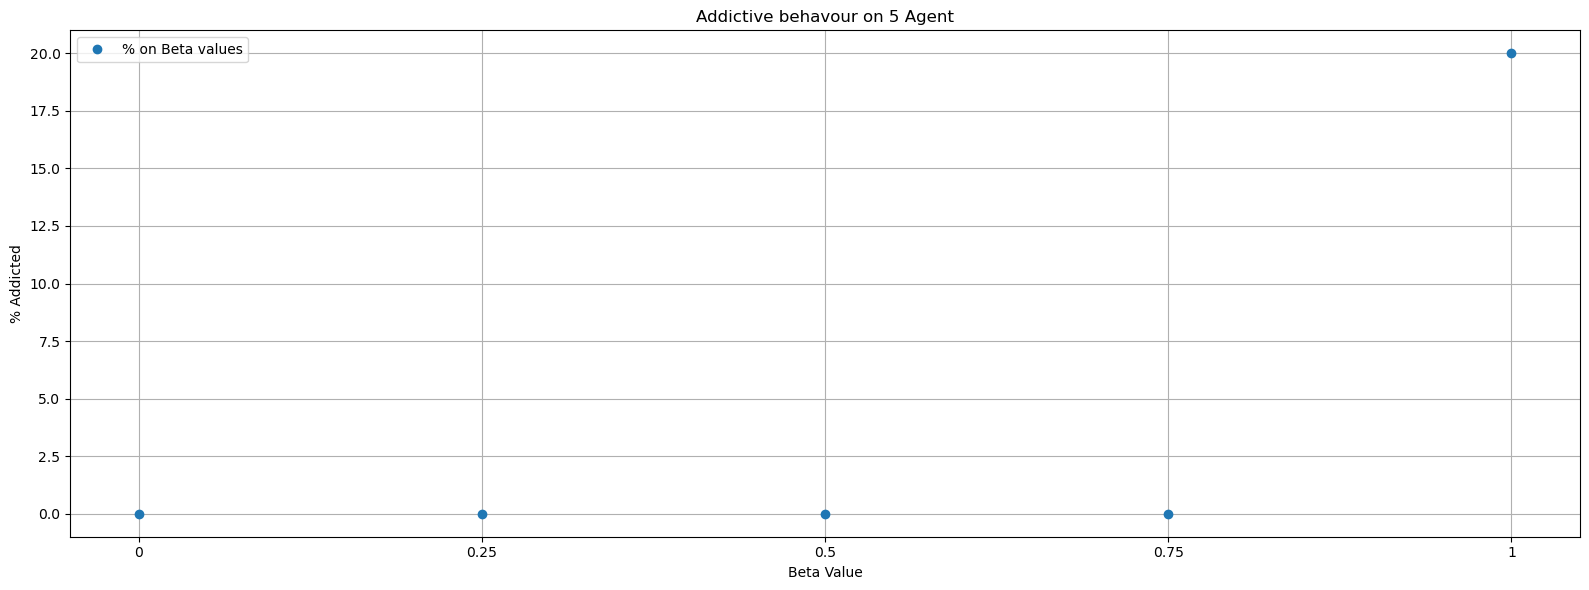

In [95]:
timestamps = np.arange(len(beta_range))

# Print addicted percentage for debugging
print(addicted_perc)

# Plot the graph
plt.figure(figsize=(16, 6))
plt.errorbar(timestamps, addicted_perc, fmt='o', capsize=10, label='% on Beta values')
plt.xticks(timestamps, beta_range)  # Set beta values as x-axis ticks
plt.title(f'Addictive behavour on {nagenti} Agent')
plt.xlabel('Beta Value')
plt.ylabel('% Addicted')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()